#A Victim Tracking System by Recognizing Signs of Violence Using Long-Short Term Memory.

In [ ]:
!pip install tf-keras-vis lime mtcnn transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=84b5c2013c7a3e5d7971e474fdd235dac34c799acd6999a28b9a009a42ecd25d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ConvLSTM2D, Attention, TimeDistributed, Concatenate, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.feature import hog
from skimage import exposure
import kagglehub
import gc
from mtcnn import MTCNN
#from feat.detector import Detector
#from gaze_tracking import GazeTracking
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
from tf_keras_vis.utils.scores import BinaryScore

In [ ]:
!pip install librosa

In [ ]:
import librosa
import librosa.display

In [ ]:
def Preprocess_Real_Life_Violence_Dataset(DATA_DIR, Output_DIR, Img_Size=(416, 416), Sample_Frac=0.1, Max_Frames=30, Fps_Target=30, Grayscale=True):

    Frame_DIR = os.path.join(Output_DIR, 'Frames')
    Face_DIR = os.path.join(Output_DIR, 'Faces')
    os.makedirs(Frame_DIR, exist_ok=True)
    os.makedirs(Face_DIR, exist_ok=True)

    print("Preprocessing RLVD Video Dataset:")

    detector = MTCNN()

    Data = {
        'Video_Paths': [],
        'Frame_Paths': [],
        'Face_Paths': [],
        'Labels': [],
        'Threat_Level': [],
        'Video_Name': []
    }

    Threat_Levels = {
        'NonViolence': 'Low',
        'Violence': 'High'
    }

    Emotion_Mapping = {
        'Violence': ['angry', 'fearful'],
        'NonViolence': ['neutral', 'calm']
    }

    Video_Files = []
    for root, _, files in os.walk(DATA_DIR):
        Video_Files.extend(os.path.join(root, f) for f in files if f.endswith(('.mp4', '.avi', '.mov', '.mp')))

    print(f"Found {len(Video_Files)} video files in {DATA_DIR}")
    print("\n")

    if not Video_Files:
        print("No video files found in the dataset.")
        return pd.DataFrame(Data)

    Num_Samples = max(1, int(len(Video_Files) * Sample_Frac))
    Sampled_Videos = np.random.choice(len(Video_Files), size=Num_Samples, replace=False)

    for Idx in tqdm(Sampled_Videos, desc="Processing Videos"):
        Video_Path = Video_Files[Idx]
        Video_Name = os.path.splitext(os.path.basename(Video_Path))[0]

        if "Real Life Violence Dataset/Violence" in Video_Path:
            Base_Label = "Violence"
        elif "Real Life Violence Dataset/NonViolence" in Video_Path:
            Base_Label = "NonViolence"
        else:
            Base_Label = "Violence" if (Video_Name.startswith("V_") and not Video_Name.startswith("NV_")) else "NonViolence"

        Label = np.random.choice(Emotion_Mapping[Base_Label])

        print(f"Processing video: {Video_Path}, Base Label: {Base_Label}, Emotion Label: {Label}")

        Video_Frame_Dir = os.path.join(Frame_DIR, Video_Name)
        Video_Face_Dir = os.path.join(Face_DIR, Video_Name)
        os.makedirs(Video_Frame_Dir, exist_ok=True)
        os.makedirs(Video_Face_Dir, exist_ok=True)

        Video = cv2.VideoCapture(Video_Path)
        if not Video.isOpened():
            print(f"Failed to open video: {Video_Path}")
            continue

        Frame_Count = int(Video.get(cv2.CAP_PROP_FRAME_COUNT))
        FPS = Video.get(cv2.CAP_PROP_FPS)
        if FPS <= 0:
            FPS = 30
        print(f"Frame count: {Frame_Count}, FPS: {FPS}")

        if Frame_Count <= 0:
            print(f"Invalid frame count for {Video_Path}: {Frame_Count}")
            Video.release()
            continue

        Sample_Interval = max(1, int(round(FPS / Fps_Target)))
        print(f"Sample interval (based on FPS {Fps_Target}): {Sample_Interval}")

        Frame_Idx = 0
        Saved_Frames = 0
        while Video.isOpened() and Saved_Frames < Max_Frames:
            Ret, Frame = Video.read()
            if not Ret:
                print(f"Failed to read frame at index {Frame_Idx} in {Video_Path}")
                break
            if Frame is None or Frame.size == 0:
                print(f"Invalid frame at index {Frame_Idx} in {Video_Path}")
                Frame_Idx += 1
                continue

            if Frame_Idx % Sample_Interval == 0:

                Frame_Resized = cv2.resize(Frame, Img_Size)

                Faces = detector.detect_faces(Frame_Resized)
                Face_Img = Frame_Resized
                if Faces:
                    x, y, w, h = Faces[0]['box']
                    Face_Img = Frame_Resized[max(0, y):y+h, max(0, x):x+w]
                    try:
                        Face_Img = cv2.resize(Face_Img, Img_Size)
                    except Exception as e:
                        print(f"Failed to resize face for frame {Frame_Idx} in {Video_Path}: {e}")
                        Frame_Idx += 1
                        continue
                else:
                    print(f"No face detected in frame {Frame_Idx} for {Video_Path}, using full frame")

                if Grayscale:
                    Frame_Processed = cv2.cvtColor(Frame_Resized, cv2.COLOR_BGR2GRAY)
                    Frame_Processed = Frame_Processed[..., np.newaxis]
                    Face_Processed = cv2.cvtColor(Face_Img, cv2.COLOR_BGR2RGB)
                    Face_Processed = cv2.cvtColor(Face_Processed, cv2.COLOR_RGB2GRAY)
                    Face_Processed = Face_Processed[..., np.newaxis]
                else:
                    Frame_Processed = Frame_Resized
                    Face_Processed = Face_Img

                Frame_Processed = Frame_Processed / 255.0
                Face_Processed = Face_Processed / 255.0

                Frame_Path = os.path.join(Video_Frame_Dir, f"Frame_{Saved_Frames}.jpg")
                Face_Path = os.path.join(Video_Face_Dir, f"Face_{Saved_Frames}.jpg")
                Frame_To_Save = (Frame_Processed * 255).astype(np.uint8)
                Face_To_Save = (Face_Processed * 255).astype(np.uint8)
                if Grayscale:
                    Frame_To_Save = Frame_To_Save.squeeze()
                    Face_To_Save = Face_To_Save.squeeze()
                print(f"Saving frame: {Frame_Path}")
                print(f"Saving face: {Face_Path}")
                if not cv2.imwrite(Frame_Path, Frame_To_Save):
                    print(f"Failed to write frame: {Frame_Path}")
                    Frame_Idx += 1
                    continue
                if not cv2.imwrite(Face_Path, Face_To_Save):
                    print(f"Failed to write face: {Face_Path}")
                    Frame_Idx += 1
                    continue

                Data['Video_Paths'].append(Video_Path)
                Data['Frame_Paths'].append(Frame_Path)
                Data['Face_Paths'].append(Face_Path)
                Data['Threat_Level'].append(Threat_Levels[Base_Label])
                Data['Labels'].append(Label)
                Data['Video_Name'].append(Video_Name)
                Saved_Frames += 1

            Frame_Idx += 1

        Video.release()
        print(f"Processed {Saved_Frames} frames for {Video_Path}")
        print("\n")

    df = pd.DataFrame(Data)
    print(f"Processed {len(df)} frames from {len(set(Data['Video_Paths']))} videos.")
    print(f"Label distribution:\n{df['Labels'].value_counts()}")
    print(f"Threat level distribution:\n{df['Threat_Level'].value_counts()}")
    print("\n")

    Output_Data_path = os.path.join(Output_DIR, 'Videos_Dataset.csv')
    df.to_csv(Output_Data_path, index=False)
    print(f"Metadata saved to {Output_Data_path}")
    print("\n")

    return df

In [ ]:
def EDA_RLVD(Dataset_Path , Num_Visualizations=5):

    df = pd.read_csv(Dataset_Path)

    print("Label Distribution:")
    #print(df['Labels'].value_counts())
    #print("\n")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Labels' , hue='Labels')
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nThreat Level Distribution:")
    #print(df['Threat_Level'].value_counts())
    #print("\n")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Threat_Level' , hue='Threat_Level')
    plt.title('Threat Level Distribution')
    plt.xlabel('Threat Level')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nVideo Length Distribution:")
    df['Video_Length'] = df['Video_Paths'].apply(lambda x:
    cv2.VideoCapture(x).get(cv2.CAP_PROP_FRAME_COUNT)
    / max(1, cv2.VideoCapture(x).get(cv2.CAP_PROP_FPS)))
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x='Video_Length', bins=30, kde=True)
    plt.title('Video Length Distribution')
    plt.xlabel('Video Length (seconds)')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nFrames per Video Statistics :")
    Frame_Counts = df.groupby('Video_Name').size()
    print(Frame_Counts.describe())
    print("\n")
    df['Frame_Dir'] = df['Frame_Paths'].apply(lambda x: os.path.dirname(x))
    Frames_Per_Video = df.groupby('Frame_Dir')['Frame_Dir'].transform('count')
    print(f"Minimum frames per video: {Frames_Per_Video.min()}")
    print(f"Maximum frames per video: {Frames_Per_Video.max()}")
    print(f"Mean frames per video: {Frames_Per_Video.mean()}")
    print(f"Median frames per video: {Frames_Per_Video.median()}")
    print("\n")

    plt.figure(figsize=(8, 6))
    sns.histplot(Frames_Per_Video , bins=30, kde=True)
    plt.title('Frames per Video Distribution')
    plt.xlabel('Frames per Video')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nVisualizing Sample Frames :")

    Sample_Frames = df.sample(n=Num_Visualizations, random_state=42)

    for Idx , Frame_Path in enumerate(Sample_Frames['Frame_Paths']):
        Frame = cv2.imread(Frame_Path)
        Frame = cv2.cvtColor(Frame, cv2.COLOR_BGR2RGB)

        if Frame is None:
            print(f"Failed to read frame: {Frame_Path}")
            continue

        plt.figure(figsize=(8, 6))
        plt.imshow(Frame)
        plt.title(f'Sample Frame {Idx + 1}')
        plt.axis('off')
        plt.show()
        print("\n")

    print("\n")

In [ ]:
!pip install fer -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
from fer import FER

  if event.key is 'enter':



In [ ]:
def Extract_FER_Emotions(df, Output_DIR, img_size=(224, 224)):

    print("Extracting Facial Emotion Recognition (FER) Probabilities:")

    Emotion_DIR = os.path.join(Output_DIR, 'Features', 'Emotions')
    os.makedirs(Emotion_DIR, exist_ok=True)

    detector = FER(mtcnn=True)
    Emotion_Paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Emotion Extraction"):
        video_name = row['Video_Name']
        face_paths = eval(row['Face_Paths']) if isinstance(row['Face_Paths'], str) else row['Face_Paths']

        print(f"Processing video: {video_name}")

        Emotion_Probs = []
        for frame_path in face_paths:
            frame = cv2.imread(frame_path)
            if frame is None:
                print(f"Failed to read frame: {frame_path}")
                Emotion_Probs.append(np.zeros(7))
                continue

            frame = cv2.resize(frame, img_size)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            try:
                result = detector.detect_emotions(frame_rgb)
                if result and len(result) > 0:
                    emotions = result[0]['emotions']
                    probs = np.array([emotions[key] for key in ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']])
                else:
                    probs = np.zeros(7)
            except Exception as e:
                print(f"Failed to extract emotions for {frame_path}: {e}")
                probs = np.zeros(7)

            Emotion_Probs.append(probs)

        Emotion_Path = os.path.join(Emotion_DIR, f"{video_name}_emotions.npy")
        np.save(Emotion_Path, np.array(Emotion_Probs))
        Emotion_Paths.append(Emotion_Path)
        print(f"Saved emotion probabilities: {Emotion_Path}")

    df['Emotion_Paths'] = Emotion_Paths
    print(f"Extracted emotion probabilities for {len(df)} videos.")
    print("\n")

    return df

In [ ]:
def Feature_Engineering_RLVD(dataset_path, Output_DIR):

    print("Starting RLVD Feature Engineering:")

    df = pd.read_csv(dataset_path)
    print(f"Loaded dataset with {len(df)} samples.")
    print("\n")

    df = df.groupby('Video_Name').agg({
        'Video_Paths': 'first',
        'Frame_Paths': list,
        'Face_Paths': list,
        'Labels': 'first',
        'Threat_Level': 'first'
    }).reset_index()

    print(f"Aggregated dataset to {len(df)} unique videos.")
    print("\n")

    df = Extract_FER_Emotions(df, Output_DIR)

    Output_Path = os.path.join(Output_DIR, 'Videos_Dataset_Features.csv')
    df.to_csv(Output_Path, index=False)
    print(f"Saved feature-engineered dataset to {Output_Path}")
    print("\n")

    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Threat_Level')
    plt.title("Distribution of Threat Levels")
    plt.xlabel("Threat Level")
    plt.ylabel("Count")
    plt.show()
    print("\n")

    return df

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import ast

In [ ]:
def Count_Valid_Sequences(video_groups, sequence_length=10):

    print("Counting Valid Sequences:")
    valid_sequences = 0
    for name, group in video_groups:
        frame_paths = sorted(group['Frame_Paths'].values)
        if len(frame_paths) >= sequence_length:
            valid_sequences += (len(frame_paths) - sequence_length + 1) // sequence_length
        print(f"Video {name}: {len(frame_paths)} frames")

    print(f"Found {valid_sequences} valid sequences.")
    print("\n")
    return valid_sequences

In [ ]:
def Video_Sequence_Generator(video_groups, sequence_length=10, img_size=(224, 224), batch_size=4, grayscale=True):

    print("Preparing Sequence Generator:")
    sequences = []
    for name, group in video_groups:
        frame_paths = sorted(group['Frame_Paths'].values)
        label = 1 if group['Threat_Level'].iloc[0] == 'High' else 0
        if len(frame_paths) >= sequence_length:
            for i in range(0, len(frame_paths) - sequence_length + 1, sequence_length):
                sequences.append((frame_paths[i:i + sequence_length], label))

    print(f"Generated {len(sequences)} sequences for processing.")
    print("\n")

    indices = np.arange(len(sequences))
    np.random.shuffle(indices)

    for idx in range(0, len(sequences), batch_size):
        batch_indices = indices[idx:idx + batch_size]
        batch_sequences = [sequences[i] for i in batch_indices]
        X, y = [], []

        print(f"Processing Batch {idx//batch_size + 1}:")
        for frame_paths, label in tqdm(batch_sequences, desc="Loading Frames", total=len(batch_sequences)):
            seq_frames = []
            try:
                for path in frame_paths:
                    if not os.path.exists(path):
                        print(f"Frame path does not exist: {path}")
                        break
                    frame = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    if frame is None:
                        print(f"Failed to read frame: {path}")
                        break
                    frame = cv2.resize(frame, img_size) / 255.0
                    if np.random.rand() > 0.5:
                        frame = cv2.flip(frame, 1)
                    frame = frame[..., np.newaxis]
                    seq_frames.append(frame)

                if len(seq_frames) == sequence_length:
                    X.append(np.array(seq_frames))
                    y.append(label)
            except Exception as e:
                print(f"Error processing sequence: {e}")
                continue

        if X:
            print(f"Yielding batch with {len(X)} sequences.")
            yield np.array(X), np.array(y)
        else:
            print("No valid sequences in batch.")
        print("\n")

In [ ]:
def Preprocess_Sequences(dataset_path, sequence_length=10, img_size=(224, 224), grayscale=True):

    print("Preprocessing Sequences:")
    df = pd.read_csv(dataset_path)
    video_groups = df.groupby('Video_Name')

    X, y = [], []
    sequence_count = 0

    for name, group in tqdm(video_groups, desc="Processing Videos"):
        frame_paths = sorted(group['Frame_Paths'].values)
        if len(frame_paths) >= sequence_length:
            for i in range(0, len(frame_paths) - sequence_length + 1, sequence_length):
                seq_frames = []
                try:
                    for path in frame_paths[i:i + sequence_length]:
                        if not os.path.exists(path):
                            print(f"Frame path does not exist: {path}")
                            continue
                        frame = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        if frame is None:
                            print(f"Failed to read frame: {path}")
                            continue
                        frame = cv2.resize(frame, img_size) / 255.0
                        frame = frame[..., np.newaxis]
                        seq_frames.append(frame)
                    if len(seq_frames) == sequence_length:
                        X.append(np.array(seq_frames))
                        y.append(1 if group['Threat_Level'].iloc[0] == 'High' else 0)
                        sequence_count += 1
                except Exception as e:
                    print(f"Error processing sequence for video {name}: {e}")
                    continue

    print(f"Processed {sequence_count} valid sequences.")
    print("\n")
    return np.array(X), np.array(y)

In [ ]:
def Build_Model(input_shape=(10, 224, 224, 1), num_classes=1):

    print("Building CNN-LSTM Model:")
    inputs = Input(shape=input_shape, name='video_input')
    x = TimeDistributed(
        tf.keras.Sequential([
            Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_1'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_2'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_3'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Flatten()
        ], name='cnn')
    )(inputs)

    x = LSTM(32, return_sequences=False, name='lstm')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu', name='dense_1', kernel_regularizer=l2(0.01))(x)
    outputs = Dense(num_classes, activation='sigmoid', name='output')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print("Model Summary:")
    model.summary()
    print("\n")
    return model

In [ ]:
def Train_Model(model, dataset_path, sequence_length=10, img_size=(224, 224), batch_size=4, epochs=20):

    print("Preparing Data for Training:")
    try:
        df = pd.read_csv(dataset_path)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return model

    if df.empty:
        print("Error: Dataset is empty.")
        return model

    video_groups = list(df.groupby('Video_Name'))
    valid_sequences = Count_Valid_Sequences(video_groups, sequence_length)

    if valid_sequences < batch_size:
        print(f"Invalid sequences ({valid_sequences}) for batch_size ({batch_size}).")
        return model

    print("Splitting Data:")
    train_idx, val_idx = train_test_split(range(len(video_groups)), test_size=0.2, random_state=42)
    train_groups = [video_groups[i] for i in train_idx]
    val_groups = [video_groups[i] for i in val_idx]

    train_sequences = Count_Valid_Sequences(train_groups, sequence_length)
    val_sequences = Count_Valid_Sequences(val_groups, sequence_length)

    print(f"Training sequences: {train_sequences}")
    print(f"Validation sequences: {val_sequences}")
    print("\n")

    print("Starting Model Training:")
    train_generator = Video_Sequence_Generator(train_groups, sequence_length, img_size, batch_size, grayscale=True)
    val_generator = Video_Sequence_Generator(val_groups, sequence_length, img_size, batch_size, grayscale=True)

    steps_per_epoch = max(1, train_sequences // batch_size)
    validation_steps = max(1, val_sequences // batch_size)

    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    )

    print("Training Complete.")
    gc.collect()
    print("\n")
    return model

In [ ]:
def Test_Model(model, dataset_path, sequence_length=10, img_size=(224, 224), batch_size=4):

    print("Testing Model:")
    try:
        df = pd.read_csv(dataset_path)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return {}

    video_groups = list(df.groupby('Video_Name'))
    valid_sequences = Count_Valid_Sequences(video_groups, sequence_length)

    if valid_sequences < batch_size:
        print(f"Invalid sequences ({valid_sequences}) for batch_size ({batch_size}).")
        return {}

    print(f"Found {valid_sequences} sequences for testing.")
    print("\n")

    print("Generating Predictions:")
    test_generator = Video_Sequence_Generator(video_groups, sequence_length, img_size, batch_size, grayscale=True)
    y_true, y_pred = [], []

    steps = max(1, valid_sequences // batch_size)
    for batch_idx, (X, y) in enumerate(tqdm(test_generator, desc="Processing Test Batches", total=steps)):
        if X.size == 0:
            print("Empty batch encountered, skipping.")
            continue
        y_true.extend(y)
        y_pred.extend((model.predict(X, verbose=0) > 0.5).astype(int).flatten())
        if batch_idx + 1 >= steps:
            break

    if not y_true:
        print("Invalid test sequences found.")
        return {}

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

    print("Test Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    print("\n")

    gc.collect()
    return metrics

In [ ]:
DATA_DIR = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")
OUTPUT_DIR = 'Processed_Real_Life_Violence'
Videos_RLVD_Dataset = Preprocess_Real_Life_Violence_Dataset(DATA_DIR, OUTPUT_DIR, Img_Size=(224, 224), Sample_Frac=0.02, Max_Frames=30, Fps_Target=30, Grayscale=True)
Dataset_Path = os.path.join(OUTPUT_DIR, 'Videos_Dataset.csv')

Preprocessing RLVD Video Dataset:
Found 4000 video files in /kaggle/input/real-life-violence-situations-dataset




Processing Videos:   0%|          | 0/80 [00:00<?, ?it/s]

Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_45.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 99, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_45.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_45/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_45/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_45.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_45/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_45/Face_1.jpg
No face detected in frame 2 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Viole

Processing Videos:   1%|▏         | 1/80 [00:06<08:05,  6.14s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_45.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_45/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_45/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_45.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_542.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 185, FPS: 37.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_542.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_542/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_542/Face_0.jpg
No face detected in frame 1 

Processing Videos:   2%|▎         | 2/80 [00:11<07:36,  5.85s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_542.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_542/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_542/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_542.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_542/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_542/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_542.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_514.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 145, FPS: 29.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/inpu

Processing Videos:   4%|▍         | 3/80 [00:17<07:35,  5.91s/it]

Saving frame: Processed_Real_Life_Violence/Frames/NV_514/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_514/Face_28.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_514/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_514/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_514.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_46.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 150, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_46.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_46/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_46/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-lif

Processing Videos:   5%|▌         | 4/80 [00:22<06:58,  5.51s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_46.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_46/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_46/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_46.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_46/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_46/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_46.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_614.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 185, FPS: 37.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/in

Processing Videos:   6%|▋         | 5/80 [00:28<07:05,  5.68s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_614.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_614/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_614/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_614.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_848.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 103, FPS: 25.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_848.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_848/Frame_0.jpg
Saving face: Process

Processing Videos:   8%|▊         | 6/80 [00:34<06:58,  5.66s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_848.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_848/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_848/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_848.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_848/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_848/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_848.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_875.avi, Base Label: NonViolence, Emotion Label: calm
Frame 

Processing Videos:   9%|▉         | 7/80 [00:39<06:35,  5.42s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_875.avi, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_875/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_875/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_875.avi, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_875/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_875/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_875.avi


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_383.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 55, FPS: 11.0
Sample

Processing Videos:  10%|█         | 8/80 [00:44<06:38,  5.53s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_383.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_383/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_383/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_383.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_735.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_735.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_735/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_735/Face_0.jpg
No face detect

Processing Videos:  11%|█▏        | 9/80 [00:49<06:18,  5.33s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_735.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_735/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_735/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_735.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_666.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 120, FPS: 24.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_666.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_666/Frame_0.jpg
Saving face: Process

Processing Videos:  12%|█▎        | 10/80 [00:56<06:49,  5.85s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_666.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_666/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_666/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_666.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_835.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 139, FPS: 25.0
Sample interval (based on FPS 30): 1
Saving frame: Processed_Real_Life_Violence/Frames/NV_835/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_835/Face_0.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_835/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_835/Fa

Processing Videos:  14%|█▍        | 11/80 [01:07<08:29,  7.39s/it]

Saving frame: Processed_Real_Life_Violence/Frames/NV_835/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_835/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_835.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_374.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 153, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_374.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_374/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_374/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Datase

Processing Videos:  15%|█▌        | 12/80 [01:13<07:40,  6.77s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_374.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_374/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_374/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_374.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_527.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 145, FPS: 29.0
Sample interval (based on FPS 30): 1
Saving frame: Processed_Real_Life_Violence/Frames/NV_527/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_527/Face_0.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_527/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_527/Face_1.jpg
Saving frame: Processed_Real

Processing Videos:  16%|█▋        | 13/80 [01:18<07:05,  6.35s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_527.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_527/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_527/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_527.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_39.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 115, FPS: 25.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_39.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_39/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_39/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-violence-

Processing Videos:  18%|█▊        | 14/80 [01:24<07:00,  6.38s/it]

Saving frame: Processed_Real_Life_Violence/Frames/NV_39/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_39/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_39.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_116.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 150, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_116.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_116/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_116/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_1

Processing Videos:  19%|█▉        | 15/80 [01:29<06:24,  5.92s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_116.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_116/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_116/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_116.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_778.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_778.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_778/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_778/Face_0.jpg
No f

Processing Videos:  20%|██        | 16/80 [01:36<06:25,  6.02s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_778.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_778/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_778/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_778.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_373.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 153, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_373.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_373/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_373/Face_0.jpg
No face detect

Processing Videos:  21%|██▏       | 17/80 [01:41<06:03,  5.77s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_373.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_373/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_373/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_373.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_373/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_373/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_373.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_621.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 145, F

Processing Videos:  22%|██▎       | 18/80 [01:47<05:58,  5.79s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_621.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_621/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_621/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_621.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_303.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 183, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_303.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_303/Frame_0.jpg
Saving

Processing Videos:  24%|██▍       | 19/80 [01:52<05:38,  5.56s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_303.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_303/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_303/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_303.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_921.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 107, FPS: 24.165
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_921.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_921/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_921/Face_0.jpg
No face detected in fr

Processing Videos:  25%|██▌       | 20/80 [01:57<05:29,  5.49s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_921.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_921/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_921/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_921.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_467.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_467.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_467/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_467/Face_0.jpg
No face detect

Processing Videos:  26%|██▋       | 21/80 [02:03<05:27,  5.55s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_467.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_467/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_467/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_467.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_491.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_491.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_491/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_491/Face_0.jpg
N

Processing Videos:  28%|██▊       | 22/80 [02:08<05:11,  5.38s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_491.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_491/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_491/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_491.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_780.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_780.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_780/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_780/Face_0.jpg
N

Processing Videos:  29%|██▉       | 23/80 [02:14<05:16,  5.55s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_780.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_780/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_780/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_780.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_780/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_780/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_780.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_987.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 150, FPS: 30.0
Sample interva

Processing Videos:  30%|███       | 24/80 [02:19<05:03,  5.42s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_987.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_987/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_987/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_987.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_987/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_987/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_987.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_833.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 153, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset

Processing Videos:  31%|███▏      | 25/80 [02:25<05:08,  5.62s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_833.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_833/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_833/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_833.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_789.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 11272, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_789.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_789/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_789/Face_0.jpg
No face detected in fram

Processing Videos:  32%|███▎      | 26/80 [02:30<04:55,  5.48s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_789.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_789/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_789/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_789.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_789/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_789/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_789.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_764.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 123, FPS: 29.97002997002997
Sample interval

Processing Videos:  34%|███▍      | 27/80 [02:35<04:51,  5.51s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_764.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_764/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_764/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_764.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_457.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 132, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_457.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_457/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_457/Face_0.jpg
No face detected in frame 

Processing Videos:  35%|███▌      | 28/80 [02:41<04:49,  5.56s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_457.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_457/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_457/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_457.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_463.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_463.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_463/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_463/Face_0.jpg
No face detect

Processing Videos:  36%|███▋      | 29/80 [02:46<04:36,  5.41s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_463.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_463/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_463/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_463.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_470.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 115, FPS: 23.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_470.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_470/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_470/Face_0.jpg
No f

Processing Videos:  38%|███▊      | 30/80 [02:52<04:36,  5.53s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_470.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_470/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_470/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_470.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_470/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_470/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_470.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_376.mp4, Base Label: Violence, Emotion Label: angry
Frame count:

Processing Videos:  39%|███▉      | 31/80 [02:58<04:34,  5.61s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_376.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_376/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_376/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_376.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_412.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 55, FPS: 11.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_412.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_412/Frame_0.jpg
Saving face: Processe

Processing Videos:  40%|████      | 32/80 [03:03<04:27,  5.57s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_412.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_412/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_412/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_412.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_181.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 111, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_181.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_181/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_181/Face_0.jpg
No face detected

Processing Videos:  41%|████▏     | 33/80 [03:09<04:20,  5.54s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_181.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_181/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_181/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_181.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_181/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_181/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_181.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_351.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 138, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-sit

Processing Videos:  42%|████▎     | 34/80 [03:14<04:15,  5.54s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_351.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_351/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_351/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_351.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_940.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 145, FPS: 29.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_940.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_940/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_940/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-violence-situations-dataset/

Processing Videos:  44%|████▍     | 35/80 [03:20<04:12,  5.61s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_940.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_940/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_940/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_940.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_940/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_940/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_940.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_914.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 145, FPS: 29.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/inpu

Processing Videos:  45%|████▌     | 36/80 [03:25<03:58,  5.42s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_914.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_914/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_914/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_914.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_914/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_914/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_914.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_444.mp4, Base Label: Violence, Emotion Label: fearful
Frame coun

Processing Videos:  46%|████▋     | 37/80 [03:31<04:00,  5.58s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_444.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_444/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_444/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_444.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_444/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_444/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_444.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_733.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 180, FPS: 30.0
Sample interval (base

Processing Videos:  48%|████▊     | 38/80 [03:36<03:47,  5.41s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_733.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_733/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_733/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_733.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_733/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_733/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_733.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_594.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 185, FPS: 37.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kagg

Processing Videos:  49%|████▉     | 39/80 [03:42<03:46,  5.53s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_594.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_594/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_594/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_594.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_392.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 55, FPS: 11.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_392.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_392/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_392/Face_0.jpg
No face dete

Processing Videos:  50%|█████     | 40/80 [03:47<03:32,  5.32s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_392.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_392/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_392/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_392.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_392/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_392/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_392.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_151.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 177, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-

Processing Videos:  51%|█████▏    | 41/80 [03:52<03:22,  5.20s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_151.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_151/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_151/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_151.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_151/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_151/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_151.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_447.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 129, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-li

Processing Videos:  52%|█████▎    | 42/80 [03:58<03:28,  5.49s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_447.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_447/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_447/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_447.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_257.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 161, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_257.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_257/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_257/Face_0.jp

Processing Videos:  54%|█████▍    | 43/80 [04:03<03:19,  5.38s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_257.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_257/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_257/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_257.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_298.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 171, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_298.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_298/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_298/Face_0.jpg
N

Processing Videos:  55%|█████▌    | 44/80 [04:09<03:23,  5.64s/it]

Saving frame: Processed_Real_Life_Violence/Frames/V_298/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_298/Face_28.jpg
Saving frame: Processed_Real_Life_Violence/Frames/V_298/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_298/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_298.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_129.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 150, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_129.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_129/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_129/Face_0

Processing Videos:  56%|█████▋    | 45/80 [04:14<03:08,  5.38s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_129.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_129/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_129/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_129.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_129/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_129/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_129.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_371.mp4, Base Label: Violence, Emotion Label: angry
Frame count:

Processing Videos:  57%|█████▊    | 46/80 [04:20<03:07,  5.51s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_371.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_371/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_371/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_371.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_110.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 125, FPS: 25.0
Sample interval (based on FPS 30): 1
Saving frame: Processed_Real_Life_Violence/Frames/NV_110/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_110/Face_0.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_110/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_110/Face_1.jpg
S

Processing Videos:  59%|█████▉    | 47/80 [04:26<03:05,  5.62s/it]

Saving frame: Processed_Real_Life_Violence/Frames/NV_110/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_110/Face_28.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_110/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_110/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_110.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_394.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 55, FPS: 11.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_394.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_394/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_394/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-

Processing Videos:  60%|██████    | 48/80 [04:30<02:51,  5.37s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_394.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_394/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_394/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_394.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_394/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_394/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_394.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_368.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 55, FPS: 11.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violen

Processing Videos:  61%|██████▏   | 49/80 [04:36<02:51,  5.54s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_368.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_368/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_368/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_368.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_935.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 145, FPS: 29.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_935.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_935/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_935/Face_0.jpg
No f

Processing Videos:  62%|██████▎   | 50/80 [04:42<02:43,  5.45s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_935.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_935/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_935/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_935.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_234.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 156, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_234.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_234/Frame_0.jpg
Saving face: Processe

Processing Videos:  64%|██████▍   | 51/80 [04:48<02:50,  5.86s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_234.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_234/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_234/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_234.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_557.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 125, FPS: 25.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_557.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_557/Frame_0.jpg
Saving face: Process

Processing Videos:  65%|██████▌   | 52/80 [04:54<02:37,  5.64s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_557.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_557/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_557/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_557.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_378.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 55, FPS: 11.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_378.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_378/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_378/Face_0.jpg
No fa

Processing Videos:  66%|██████▋   | 53/80 [04:59<02:32,  5.65s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_378.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_378/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_378/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_378.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_973.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 150, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_973.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_973/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_973/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-violence-situation

Processing Videos:  68%|██████▊   | 54/80 [05:05<02:26,  5.63s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_973.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_973/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_973/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_973.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_973/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_973/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_973.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_935.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 123, FPS: 29.769
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/rea

Processing Videos:  69%|██████▉   | 55/80 [05:10<02:17,  5.51s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_935.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_935/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_935/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_935.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_87.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 126, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_87.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_87/Frame_0.jpg
Saving fac

Processing Videos:  70%|███████   | 56/80 [05:16<02:16,  5.67s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_87.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_87/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_87/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_87.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_87/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_87/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_87.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_586.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame coun

Processing Videos:  71%|███████▏  | 57/80 [05:21<02:05,  5.43s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_586.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_586/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_586/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_586.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_586/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_586/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_586.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_948.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 145, FPS: 29.0
Sample i

Processing Videos:  72%|███████▎  | 58/80 [05:27<02:03,  5.61s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_948.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_948/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_948/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_948.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_632.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 150, FPS: 29.97
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_632.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_632/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_632/Face_0.jpg
No face detecte

Processing Videos:  74%|███████▍  | 59/80 [05:32<01:55,  5.50s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_632.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_632/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_632/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_632.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_632/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_632/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_632.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_395.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 96, FPS: 29.97002997002997
Sample interval (b

Processing Videos:  75%|███████▌  | 60/80 [05:38<01:51,  5.55s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_395.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_395/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_395/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_395.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_327.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 129, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_327.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_327/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_327/Face_0.jpg
No face detec

Processing Videos:  76%|███████▋  | 61/80 [05:43<01:44,  5.52s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_327.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_327/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_327/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_327.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_327/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_327/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_327.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_272.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 162, FPS: 30.

Processing Videos:  78%|███████▊  | 62/80 [05:49<01:38,  5.47s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_272.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_272/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_272/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_272.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_822.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 126, FPS: 30.0
Sample interval (based on FPS 30): 1
Saving frame: Processed_Real_Life_Violence/Frames/V_822/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_822/Face_0.jpg
Saving frame: Processed_Real_Life_Violence/Frames/V_822/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_822/Face_1.jpg
No face d

Processing Videos:  79%|███████▉  | 63/80 [05:55<01:38,  5.80s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_822.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_822/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_822/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_822.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_601.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 185, FPS: 37.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_601.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_601/Frame_0.jpg
Saving face: Processed_Real_Lif

Processing Videos:  80%|████████  | 64/80 [06:01<01:31,  5.69s/it]

Saving frame: Processed_Real_Life_Violence/Frames/V_601/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_601/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_601.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_601/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_601/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_601.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_483.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 144, FPS: 29.97
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/

Processing Videos:  81%|████████▏ | 65/80 [06:07<01:26,  5.76s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_483.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_483/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_483/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_483.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_483/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_483/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_483.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_806.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 115, F

Processing Videos:  82%|████████▎ | 66/80 [06:12<01:18,  5.61s/it]

Saving frame: Processed_Real_Life_Violence/Frames/NV_806/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_806/Face_28.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_806/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_806/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_806.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_497.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 144, FPS: 29.97
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_497.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_497/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_497/Face_0.jpg
No face detected in frame 1 for /kaggle/input/real-life-vio

Processing Videos:  84%|████████▍ | 67/80 [06:18<01:14,  5.74s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_497.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_497/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_497/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_497.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_497/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_497/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_497.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_875.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 150, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset

Processing Videos:  85%|████████▌ | 68/80 [06:23<01:06,  5.57s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_875.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_875/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_875/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_875.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_875/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_875/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_875.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_356.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 180, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggl

Processing Videos:  86%|████████▋ | 69/80 [06:29<01:01,  5.62s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_356.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_356/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_356/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_356.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_173.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 108, FPS: 20.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_173.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_173/Frame_0.jpg
Saving face: Processed_Real_L

Processing Videos:  88%|████████▊ | 70/80 [06:35<00:56,  5.68s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_173.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_173/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_173/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_173.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_426.mp4, Base Label: NonViolence, Emotion Label: calm
Frame count: 55, FPS: 11.0
Sample interval (based on FPS 30): 1
Saving frame: Processed_Real_Life_Violence/Frames/NV_426/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_426/Face_0.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_426/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_426/Face_1.jpg
Saving frame: Processed_Real_Lif

Processing Videos:  89%|████████▉ | 71/80 [06:40<00:49,  5.53s/it]

Saving frame: Processed_Real_Life_Violence/Frames/NV_426/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_426/Face_28.jpg
Saving frame: Processed_Real_Life_Violence/Frames/NV_426/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_426/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_426.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_503.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 150, FPS: 29.97
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_503.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_503/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_503/Face_0.jpg
No face detected in frame 1 for

Processing Videos:  90%|█████████ | 72/80 [06:46<00:45,  5.73s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_503.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_503/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_503/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_503.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_130.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 150, FPS: 30.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_130.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_130/Frame_0.jpg
Saving face: Proc

Processing Videos:  91%|█████████▏| 73/80 [06:51<00:38,  5.56s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_130.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_130/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_130/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_130.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_130/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_130/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/NonViolence/NV_130.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_547.mp4, Base Label: Violence, Emotion Label: angry
Frame count: 185, FPS: 37.0
Sample interva

Processing Videos:  92%|█████████▎| 74/80 [06:58<00:36,  6.01s/it]

Saving frame: Processed_Real_Life_Violence/Frames/V_547/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_547/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_547.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_861.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 147, FPS: 30.0
Sample interval (based on FPS 30): 1
Saving frame: Processed_Real_Life_Violence/Frames/V_861/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_861/Face_0.jpg
Saving frame: Processed_Real_Life_Violence/Frames/V_861/Frame_1.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_861/Face_1.jpg
Saving frame: Processed_Real_Life_Violence/Frames/V_861/Frame_2.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_861/Face_2.jpg
No face detected in frame 3 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Viol

Processing Videos:  94%|█████████▍| 75/80 [07:04<00:29,  5.99s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_861.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_861/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_861/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_861.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_391.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 150, FPS: 29.97002997002997
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_391.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_391/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_391/Face_0.jpg
No face det

Processing Videos:  95%|█████████▌| 76/80 [07:10<00:24,  6.04s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_391.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_391/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_391/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_391.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_391/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_391/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_391.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_215.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 156, FPS: 30.

Processing Videos:  96%|█████████▋| 77/80 [07:16<00:18,  6.02s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_215.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_215/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_215/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_215.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_928.mp4, Base Label: NonViolence, Emotion Label: neutral
Frame count: 145, FPS: 29.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_928.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_928/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_928/Face_0.jpg
No face det

Processing Videos:  98%|█████████▊| 78/80 [07:23<00:12,  6.17s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_928.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/NV_928/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/NV_928/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_928.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_156.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 98, FPS: 20.0
Sample interval (based on FPS 30): 1
No face detected in frame 0 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_156.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_156/Frame_0.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_156/Face_0.jpg
No face detecte

Processing Videos:  99%|█████████▉| 79/80 [07:28<00:05,  5.92s/it]

No face detected in frame 28 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_156.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_156/Frame_28.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_156/Face_28.jpg
No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_156.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_156/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_156/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset/Violence/V_156.mp4


Processing video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_254.mp4, Base Label: Violence, Emotion Label: fearful
Frame count: 162, FPS: 30.0
Sample interval (based on FP

Processing Videos: 100%|██████████| 80/80 [07:34<00:00,  5.68s/it]

No face detected in frame 29 for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_254.mp4, using full frame
Saving frame: Processed_Real_Life_Violence/Frames/V_254/Frame_29.jpg
Saving face: Processed_Real_Life_Violence/Faces/V_254/Face_29.jpg
Processed 30 frames for /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_254.mp4


Processed 2400 frames from 80 videos.
Label distribution:
Labels
fearful    750
calm       570
angry      570
neutral    510
Name: count, dtype: int64
Threat level distribution:
Threat_Level
High    1320
Low     1080
Name: count, dtype: int64


Metadata saved to Processed_Real_Life_Violence/Videos_Dataset.csv




Label Distribution:


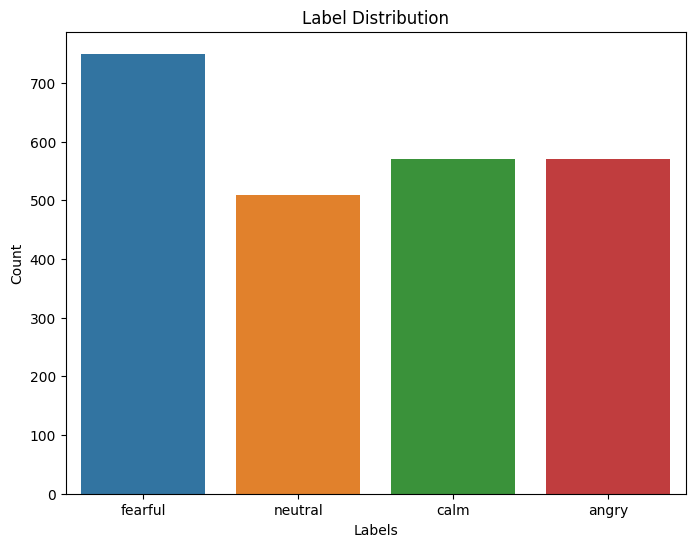




Threat Level Distribution:


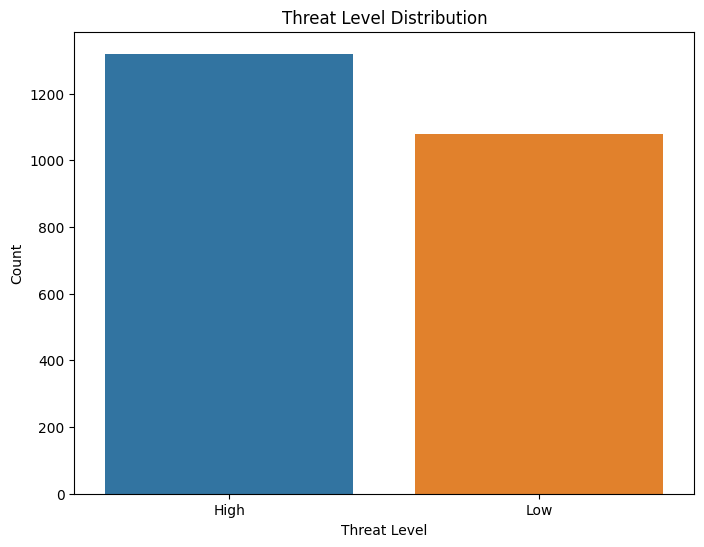




Video Length Distribution:


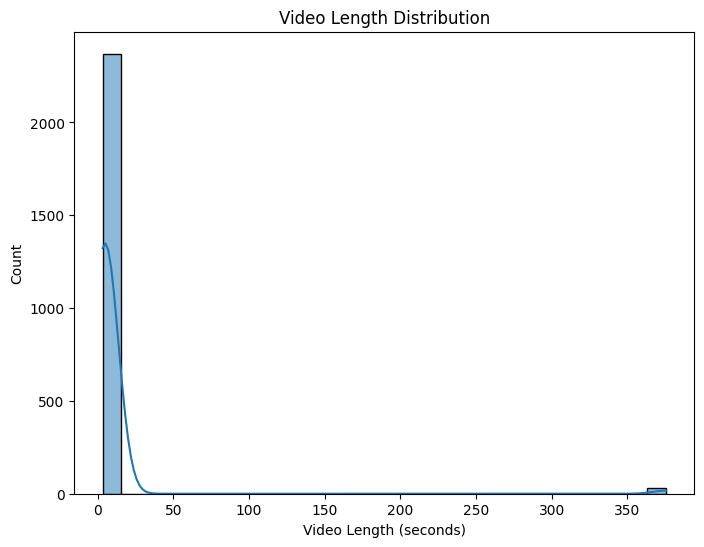




Frames per Video Statistics :
count    80.0
mean     30.0
std       0.0
min      30.0
25%      30.0
50%      30.0
75%      30.0
max      30.0
dtype: float64


Minimum frames per video: 30
Maximum frames per video: 30
Mean frames per video: 30.0
Median frames per video: 30.0




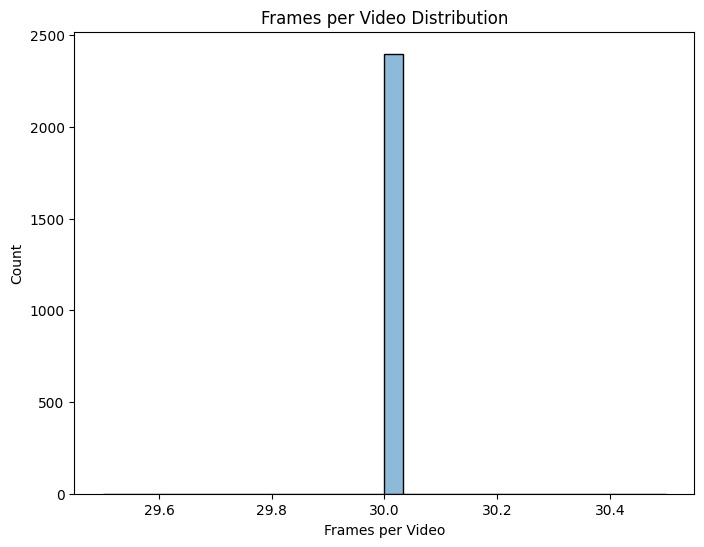




Visualizing Sample Frames :


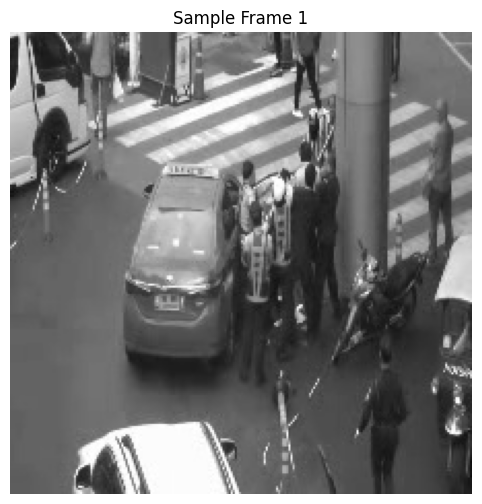

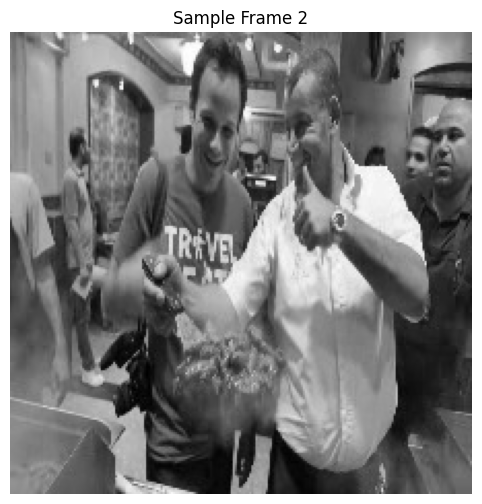

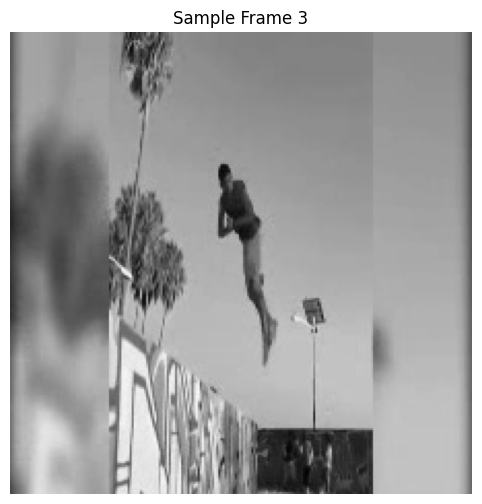

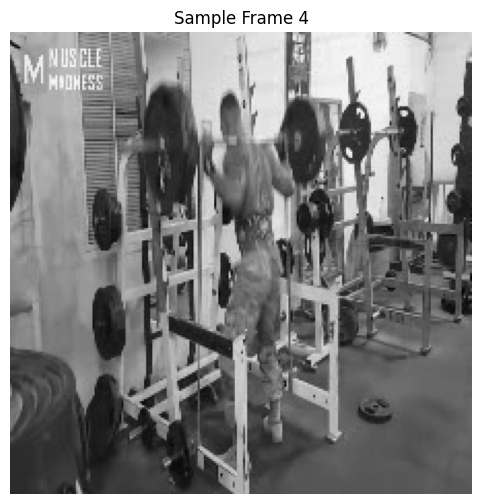

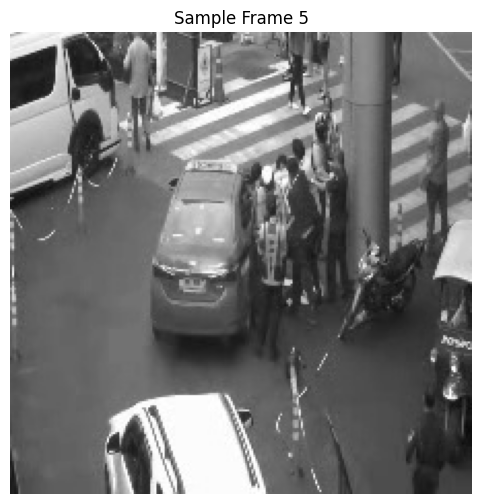

In [ ]:
EDA_RLVD(Dataset_Path)

Starting RLVD Feature Engineering:
Loaded dataset with 2400 samples.


Aggregated dataset to 80 unique videos.


Extracting Facial Emotion Recognition (FER) Probabilities:


Processing Emotion Extraction:   0%|          | 0/80 [00:00<?, ?it/s]

Processing video: NV_110


Processing Emotion Extraction:   1%|▏         | 1/80 [00:04<05:35,  4.24s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_110_emotions.npy
Processing video: NV_116


Processing Emotion Extraction:   2%|▎         | 2/80 [00:05<03:07,  2.40s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_116_emotions.npy
Processing video: NV_129


Processing Emotion Extraction:   4%|▍         | 3/80 [00:06<02:09,  1.68s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_129_emotions.npy
Processing video: NV_130


Processing Emotion Extraction:   5%|▌         | 4/80 [00:07<01:46,  1.40s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_130_emotions.npy
Processing video: NV_257


Processing Emotion Extraction:   6%|▋         | 5/80 [00:08<01:41,  1.36s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_257_emotions.npy
Processing video: NV_368


Processing Emotion Extraction:   8%|▊         | 6/80 [00:11<02:14,  1.82s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_368_emotions.npy
Processing video: NV_378


Processing Emotion Extraction:   9%|▉         | 7/80 [00:12<02:01,  1.66s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_378_emotions.npy
Processing video: NV_383


Processing Emotion Extraction:  10%|█         | 8/80 [00:13<01:47,  1.49s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_383_emotions.npy
Processing video: NV_39


Processing Emotion Extraction:  11%|█▏        | 9/80 [00:16<02:27,  2.07s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_39_emotions.npy
Processing video: NV_392


Processing Emotion Extraction:  12%|█▎        | 10/80 [00:18<02:07,  1.82s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_392_emotions.npy
Processing video: NV_394


Processing Emotion Extraction:  14%|█▍        | 11/80 [00:19<01:49,  1.59s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_394_emotions.npy
Processing video: NV_412


Processing Emotion Extraction:  15%|█▌        | 12/80 [00:20<01:31,  1.34s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_412_emotions.npy
Processing video: NV_426


Processing Emotion Extraction:  16%|█▋        | 13/80 [00:22<02:01,  1.81s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_426_emotions.npy
Processing video: NV_46


Processing Emotion Extraction:  18%|█▊        | 14/80 [00:23<01:41,  1.54s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_46_emotions.npy
Processing video: NV_463


Processing Emotion Extraction:  19%|█▉        | 15/80 [00:24<01:25,  1.32s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_463_emotions.npy
Processing video: NV_467


Processing Emotion Extraction:  20%|██        | 16/80 [00:25<01:19,  1.25s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_467_emotions.npy
Processing video: NV_470


Processing Emotion Extraction:  21%|██▏       | 17/80 [00:26<01:11,  1.14s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_470_emotions.npy
Processing video: NV_491


Processing Emotion Extraction:  22%|██▎       | 18/80 [00:27<01:12,  1.18s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_491_emotions.npy
Processing video: NV_514


Processing Emotion Extraction:  24%|██▍       | 19/80 [00:31<01:53,  1.86s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_514_emotions.npy
Processing video: NV_527


Processing Emotion Extraction:  25%|██▌       | 20/80 [00:34<02:09,  2.16s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_527_emotions.npy
Processing video: NV_557


Processing Emotion Extraction:  26%|██▋       | 21/80 [00:35<01:48,  1.83s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_557_emotions.npy
Processing video: NV_586


Processing Emotion Extraction:  28%|██▊       | 22/80 [00:36<01:31,  1.58s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_586_emotions.npy
Processing video: NV_621


Processing Emotion Extraction:  29%|██▉       | 23/80 [00:37<01:17,  1.36s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_621_emotions.npy
Processing video: NV_666


Processing Emotion Extraction:  30%|███       | 24/80 [00:39<01:35,  1.70s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_666_emotions.npy
Processing video: NV_733


Processing Emotion Extraction:  31%|███▏      | 25/80 [00:42<01:49,  1.98s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_733_emotions.npy
Processing video: NV_778


Processing Emotion Extraction:  32%|███▎      | 26/80 [00:44<01:44,  1.94s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_778_emotions.npy
Processing video: NV_780


Processing Emotion Extraction:  34%|███▍      | 27/80 [00:45<01:28,  1.67s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_780_emotions.npy
Processing video: NV_806


Processing Emotion Extraction:  35%|███▌      | 28/80 [00:48<01:51,  2.14s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_806_emotions.npy
Processing video: NV_835


Processing Emotion Extraction:  36%|███▋      | 29/80 [00:51<02:04,  2.44s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_835_emotions.npy
Processing video: NV_848


Processing Emotion Extraction:  38%|███▊      | 30/80 [00:52<01:40,  2.00s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_848_emotions.npy
Processing video: NV_87


Processing Emotion Extraction:  39%|███▉      | 31/80 [00:55<01:55,  2.36s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_87_emotions.npy
Processing video: NV_875


Processing Emotion Extraction:  40%|████      | 32/80 [00:56<01:35,  1.98s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_875_emotions.npy
Processing video: NV_914


Processing Emotion Extraction:  41%|████▏     | 33/80 [00:57<01:17,  1.66s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_914_emotions.npy
Processing video: NV_928


Processing Emotion Extraction:  42%|████▎     | 34/80 [00:58<01:10,  1.54s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_928_emotions.npy
Processing video: NV_935


Processing Emotion Extraction:  44%|████▍     | 35/80 [01:00<01:05,  1.45s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_935_emotions.npy
Processing video: NV_948


Processing Emotion Extraction:  45%|████▌     | 36/80 [01:01<01:00,  1.37s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/NV_948_emotions.npy
Processing video: V_151


Processing Emotion Extraction:  46%|████▋     | 37/80 [01:02<00:53,  1.24s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_151_emotions.npy
Processing video: V_156


Processing Emotion Extraction:  48%|████▊     | 38/80 [01:03<00:49,  1.19s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_156_emotions.npy
Processing video: V_173


Processing Emotion Extraction:  49%|████▉     | 39/80 [01:04<00:45,  1.12s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_173_emotions.npy
Processing video: V_181


Processing Emotion Extraction:  50%|█████     | 40/80 [01:05<00:44,  1.10s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_181_emotions.npy
Processing video: V_215


Processing Emotion Extraction:  51%|█████▏    | 41/80 [01:07<00:51,  1.31s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_215_emotions.npy
Processing video: V_234


Processing Emotion Extraction:  52%|█████▎    | 42/80 [01:09<00:55,  1.46s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_234_emotions.npy
Processing video: V_254


Processing Emotion Extraction:  54%|█████▍    | 43/80 [01:10<00:53,  1.45s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_254_emotions.npy
Processing video: V_272


Processing Emotion Extraction:  55%|█████▌    | 44/80 [01:11<00:49,  1.38s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_272_emotions.npy
Processing video: V_298


Processing Emotion Extraction:  56%|█████▋    | 45/80 [01:14<01:00,  1.72s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_298_emotions.npy
Processing video: V_303


Processing Emotion Extraction:  57%|█████▊    | 46/80 [01:15<00:51,  1.51s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_303_emotions.npy
Processing video: V_327


Processing Emotion Extraction:  59%|█████▉    | 47/80 [01:16<00:44,  1.34s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_327_emotions.npy
Processing video: V_351


Processing Emotion Extraction:  60%|██████    | 48/80 [01:17<00:40,  1.25s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_351_emotions.npy
Processing video: V_356


Processing Emotion Extraction:  61%|██████▏   | 49/80 [01:18<00:36,  1.17s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_356_emotions.npy
Processing video: V_371


Processing Emotion Extraction:  62%|██████▎   | 50/80 [01:19<00:41,  1.37s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_371_emotions.npy
Processing video: V_373


Processing Emotion Extraction:  64%|██████▍   | 51/80 [01:21<00:40,  1.40s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_373_emotions.npy
Processing video: V_374


Processing Emotion Extraction:  65%|██████▌   | 52/80 [01:22<00:36,  1.29s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_374_emotions.npy
Processing video: V_376


Processing Emotion Extraction:  66%|██████▋   | 53/80 [01:23<00:33,  1.23s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_376_emotions.npy
Processing video: V_391


Processing Emotion Extraction:  68%|██████▊   | 54/80 [01:24<00:31,  1.22s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_391_emotions.npy
Processing video: V_395


Processing Emotion Extraction:  69%|██████▉   | 55/80 [01:25<00:28,  1.14s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_395_emotions.npy
Processing video: V_444


Processing Emotion Extraction:  70%|███████   | 56/80 [01:26<00:24,  1.03s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_444_emotions.npy
Processing video: V_447


Processing Emotion Extraction:  71%|███████▏  | 57/80 [01:27<00:23,  1.04s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_447_emotions.npy
Processing video: V_45


Processing Emotion Extraction:  72%|███████▎  | 58/80 [01:28<00:21,  1.02it/s]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_45_emotions.npy
Processing video: V_457


Processing Emotion Extraction:  74%|███████▍  | 59/80 [01:29<00:21,  1.02s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_457_emotions.npy
Processing video: V_483


Processing Emotion Extraction:  75%|███████▌  | 60/80 [01:30<00:21,  1.10s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_483_emotions.npy
Processing video: V_497


Processing Emotion Extraction:  76%|███████▋  | 61/80 [01:31<00:20,  1.09s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_497_emotions.npy
Processing video: V_503


Processing Emotion Extraction:  78%|███████▊  | 62/80 [01:33<00:23,  1.30s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_503_emotions.npy
Processing video: V_542


Processing Emotion Extraction:  79%|███████▉  | 63/80 [01:35<00:23,  1.40s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_542_emotions.npy
Processing video: V_547


Processing Emotion Extraction:  80%|████████  | 64/80 [01:38<00:31,  1.96s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_547_emotions.npy
Processing video: V_594


Processing Emotion Extraction:  81%|████████▏ | 65/80 [01:39<00:26,  1.75s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_594_emotions.npy
Processing video: V_601


Processing Emotion Extraction:  82%|████████▎ | 66/80 [01:40<00:21,  1.57s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_601_emotions.npy
Processing video: V_614


Processing Emotion Extraction:  84%|████████▍ | 67/80 [01:42<00:18,  1.44s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_614_emotions.npy
Processing video: V_632


Processing Emotion Extraction:  85%|████████▌ | 68/80 [01:43<00:17,  1.49s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_632_emotions.npy
Processing video: V_735


Processing Emotion Extraction:  86%|████████▋ | 69/80 [01:45<00:17,  1.57s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_735_emotions.npy
Processing video: V_764


Processing Emotion Extraction:  88%|████████▊ | 70/80 [01:47<00:16,  1.65s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_764_emotions.npy
Processing video: V_789


Processing Emotion Extraction:  89%|████████▉ | 71/80 [01:48<00:14,  1.57s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_789_emotions.npy
Processing video: V_822


Processing Emotion Extraction:  90%|█████████ | 72/80 [01:50<00:13,  1.74s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_822_emotions.npy
Processing video: V_833


Processing Emotion Extraction:  91%|█████████▏| 73/80 [01:51<00:10,  1.54s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_833_emotions.npy
Processing video: V_861


Processing Emotion Extraction:  92%|█████████▎| 74/80 [01:53<00:09,  1.55s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_861_emotions.npy
Processing video: V_875


Processing Emotion Extraction:  94%|█████████▍| 75/80 [01:54<00:07,  1.43s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_875_emotions.npy
Processing video: V_921


Processing Emotion Extraction:  95%|█████████▌| 76/80 [01:55<00:05,  1.34s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_921_emotions.npy
Processing video: V_935


Processing Emotion Extraction:  96%|█████████▋| 77/80 [01:57<00:04,  1.41s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_935_emotions.npy
Processing video: V_940


Processing Emotion Extraction:  98%|█████████▊| 78/80 [01:59<00:03,  1.53s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_940_emotions.npy
Processing video: V_973


Processing Emotion Extraction:  99%|█████████▉| 79/80 [02:00<00:01,  1.51s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_973_emotions.npy
Processing video: V_987


Processing Emotion Extraction: 100%|██████████| 80/80 [02:01<00:00,  1.52s/it]

Saved emotion probabilities: Feature_Processed_RLVD/Features/Emotions/V_987_emotions.npy
Extracted emotion probabilities for 80 videos.


Saved feature-engineered dataset to Feature_Processed_RLVD/Videos_Dataset_Features.csv




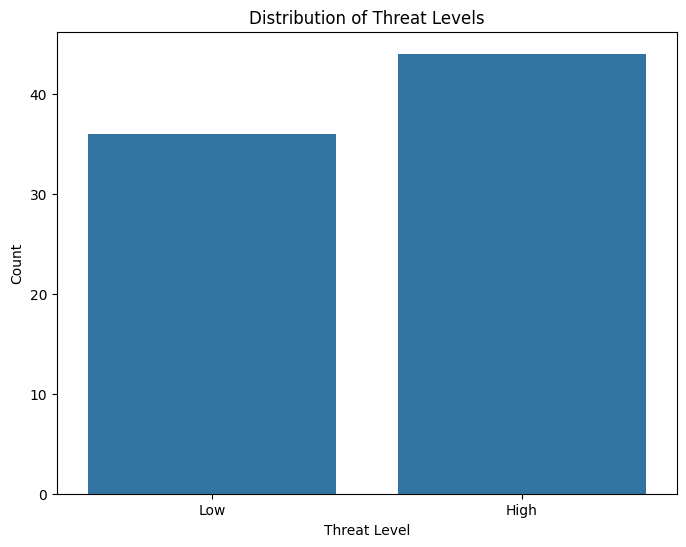

In [ ]:
OUTPUT_DIR = 'Feature_Processed_RLVD'
Features_RLVD = Feature_Engineering_RLVD(Dataset_Path, OUTPUT_DIR)

In [ ]:
dataset_path = '/content/Processed_Real_Life_Violence/Videos_Dataset.csv'

model = Build_Model(input_shape=(10, 224, 224, 1), num_classes=1)
model = Train_Model(model, dataset_path, sequence_length=10, img_size=(224, 224), batch_size=4, epochs=20)

Building CNN-LSTM Model:
Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ video_input (InputLayer)        │ (None, 10, 224, 224,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 50176)      │        23,744 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │     6,426,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,451,041 (24.61 MB)

 Trainable params: 6,450,817 (24.61 MB)

 Non-trainable params: 224 (896.00 B)



Preparing Data for Training:
Counting Valid Sequences:
Video NV_110: 30 frames
Video NV_116: 30 frames
Video NV_129: 30 frames
Video NV_130: 30 frames
Video NV_257: 30 frames
Video NV_368: 30 frames
Video NV_378: 30 frames
Video NV_383: 30 frames
Video NV_39: 30 frames
Video NV_392: 30 frames
Video NV_394: 30 frames
Video NV_412: 30 frames
Video NV_426: 30 frames
Video NV_46: 30 frames
Video NV_463: 30 frames
Video NV_467: 30 frames
Video NV_470: 30 frames
Video NV_491: 30 frames
Video NV_514: 30 frames
Video NV_527: 30 frames
Video NV_557: 30 frames
Video NV_586: 30 frames
Video NV_621: 30 frames
Video NV_666: 30 frames
Video NV_733: 30 frames
Video NV_778: 30 frames
Video NV_780: 30 frames
Video NV_806: 30 frames
Video NV_835: 30 frames
Video NV_848: 30 frames
Video NV_87: 30 frames
Video NV_875: 30 frames
Video NV_914: 30 frames
Video NV_928: 30 frames
Video NV_935: 30 frames
Video NV_948: 30 frames
Video V_151: 30 frames
Video V_156: 30 frames
Video V_173: 30 frames
Video V_181: 

Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 67.22it/s]


Yielding batch with 4 sequences.


Processing Batch 2:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 150.34it/s]

Yielding batch with 4 sequences.
Epoch 1/20


 1/32 ━━━━━━━━━━━━━━━━━━━━ 9:57 19s/step - accuracy: 0.2500 - loss: 1.1338

Processing Batch 3:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 29.04it/s]

Yielding batch with 4 sequences.


 2/32 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - accuracy: 0.1875 - loss: 1.1214 

Processing Batch 4:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 45.53it/s]

Yielding batch with 4 sequences.


 3/32 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - accuracy: 0.2361 - loss: 1.0791

Processing Batch 5:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 86.48it/s]

Yielding batch with 4 sequences.


 4/32 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - accuracy: 0.2708 - loss: 1.0527

Processing Batch 6:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 64.63it/s]

Yielding batch with 4 sequences.


 5/32 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.2867 - loss: 1.0440

Processing Batch 7:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 87.21it/s]

Yielding batch with 4 sequences.


 6/32 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - accuracy: 0.3014 - loss: 1.0335

Processing Batch 8:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 53.26it/s]

Yielding batch with 4 sequences.


 7/32 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - accuracy: 0.3145 - loss: 1.0288

Processing Batch 9:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 105.68it/s]

Yielding batch with 4 sequences.


 8/32 ━━━━━━━━━━━━━━━━━━━━ 1:21 3s/step - accuracy: 0.3220 - loss: 1.0240

Processing Batch 10:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 96.15it/s]

Yielding batch with 4 sequences.


 9/32 ━━━━━━━━━━━━━━━━━━━━ 1:19 3s/step - accuracy: 0.3264 - loss: 1.0202

Processing Batch 11:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 32.67it/s]

Yielding batch with 4 sequences.


10/32 ━━━━━━━━━━━━━━━━━━━━ 1:15 3s/step - accuracy: 0.3287 - loss: 1.0171

Processing Batch 12:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 96.96it/s]

Yielding batch with 4 sequences.


11/32 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - accuracy: 0.3319 - loss: 1.0141

Processing Batch 13:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 90.35it/s]

Yielding batch with 4 sequences.


12/32 ━━━━━━━━━━━━━━━━━━━━ 1:07 3s/step - accuracy: 0.3338 - loss: 1.0122

Processing Batch 14:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 87.11it/s]

Yielding batch with 4 sequences.


13/32 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.3347 - loss: 1.0113

Processing Batch 15:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 33.56it/s]

Yielding batch with 4 sequences.


14/32 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.3363 - loss: 1.0101

Processing Batch 16:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 93.76it/s]

Yielding batch with 4 sequences.


15/32 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.3394 - loss: 1.0088 

Processing Batch 17:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 52.54it/s]

Yielding batch with 4 sequences.


16/32 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.3426 - loss: 1.0075

Processing Batch 18:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 101.92it/s]

Yielding batch with 4 sequences.


17/32 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.3458 - loss: 1.0061

Processing Batch 19:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 42.66it/s]

Yielding batch with 4 sequences.


18/32 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.3498 - loss: 1.0045

Processing Batch 20:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 47.65it/s]

Yielding batch with 4 sequences.


19/32 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.3542 - loss: 1.0027

Processing Batch 21:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 56.96it/s]

Yielding batch with 4 sequences.


20/32 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3590 - loss: 1.0010

Processing Batch 22:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 46.31it/s]

Yielding batch with 4 sequences.


21/32 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3623 - loss: 0.9995

Processing Batch 23:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 24.29it/s]

Yielding batch with 4 sequences.


22/32 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3655 - loss: 0.9983

Processing Batch 24:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 103.51it/s]

Yielding batch with 4 sequences.


23/32 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.3685 - loss: 0.9969

Processing Batch 25:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 44.87it/s]

Yielding batch with 4 sequences.


24/32 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.3718 - loss: 0.9954

Processing Batch 26:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 96.42it/s]

Yielding batch with 4 sequences.


25/32 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.3753 - loss: 0.9937

Processing Batch 27:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 29.35it/s]

Yielding batch with 4 sequences.


26/32 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3790 - loss: 0.9919

Processing Batch 28:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 65.62it/s]

Yielding batch with 4 sequences.


27/32 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3825 - loss: 0.9902

Processing Batch 29:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 51.03it/s]

Yielding batch with 4 sequences.


28/32 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3854 - loss: 0.9888

Processing Batch 30:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 44.17it/s]

Yielding batch with 4 sequences.


29/32 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3879 - loss: 0.9875

Processing Batch 31:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 28.73it/s]

Yielding batch with 4 sequences.


30/32 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3908 - loss: 0.9860 

Processing Batch 32:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 75.80it/s]

Yielding batch with 4 sequences.


31/32 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3930 - loss: 0.9848

Processing Batch 33:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 48.62it/s]

Yielding batch with 4 sequences.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3951 - loss: 0.9837Preparing Sequence Generator:
Generated 48 sequences for processing.


Processing Batch 1:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 144.53it/s]


Yielding batch with 4 sequences.


Processing Batch 2:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 143.06it/s]

Yielding batch with 4 sequences.




Processing Batch 3:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 41.91it/s]

Yielding batch with 4 sequences.




Processing Batch 4:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 50.72it/s]

Yielding batch with 4 sequences.




Processing Batch 5:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 40.67it/s]

Yielding batch with 4 sequences.




Processing Batch 6:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 34.19it/s]

Yielding batch with 4 sequences.




Processing Batch 7:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 44.66it/s]

Yielding batch with 4 sequences.




Processing Batch 8:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 56.76it/s]

Yielding batch with 4 sequences.




Processing Batch 9:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 98.99it/s]

Yielding batch with 4 sequences.


32/32 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.3971 - loss: 0.9826 - val_accuracy: 0.5625 - val_loss: 0.8623 - learning_rate: 1.0000e-04
Epoch 2/20


Processing Batch 34:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 84.78it/s]

Yielding batch with 4 sequences.


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 1.0000 - loss: 0.7465

Processing Batch 35:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 35.11it/s]

Yielding batch with 4 sequences.


 2/32 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - accuracy: 0.8750 - loss: 0.8001

Processing Batch 36:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 114.82it/s]

Yielding batch with 4 sequences.


 3/32 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.7500 - loss: 0.8377

Processing Batch 37:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 37.89it/s]

Yielding batch with 4 sequences.


 4/32 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - accuracy: 0.6719 - loss: 0.8572

Processing Batch 38:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 44.46it/s]

Yielding batch with 4 sequences.


 5/32 ━━━━━━━━━━━━━━━━━━━━ 1:31 3s/step - accuracy: 0.6175 - loss: 0.8732

Processing Batch 39:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 68.72it/s]

Yielding batch with 4 sequences.


 6/32 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - accuracy: 0.5840 - loss: 0.8817

Processing Batch 40:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 108.23it/s]

Yielding batch with 4 sequences.


 7/32 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - accuracy: 0.5618 - loss: 0.8876

Processing Batch 41:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 58.89it/s]

Yielding batch with 4 sequences.


 8/32 ━━━━━━━━━━━━━━━━━━━━ 1:21 3s/step - accuracy: 0.5502 - loss: 0.8894

Processing Batch 42:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 57.83it/s]

Yielding batch with 4 sequences.


 9/32 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step - accuracy: 0.5354 - loss: 0.8924

Processing Batch 43:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 59.96it/s]

Yielding batch with 4 sequences.


10/32 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.5243 - loss: 0.8948

Processing Batch 44:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 94.81it/s]

Yielding batch with 4 sequences.


11/32 ━━━━━━━━━━━━━━━━━━━━ 1:10 3s/step - accuracy: 0.5180 - loss: 0.8964

Processing Batch 45:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 37.20it/s]

Yielding batch with 4 sequences.


12/32 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.5130 - loss: 0.8980

Processing Batch 46:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 82.16it/s]

Yielding batch with 4 sequences.


13/32 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - accuracy: 0.5120 - loss: 0.8985

Processing Batch 47:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 42.08it/s]

Yielding batch with 4 sequences.


14/32 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5124 - loss: 0.8986 

Processing Batch 48:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 99.53it/s]

Yielding batch with 4 sequences.


15/32 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5138 - loss: 0.8985

16/32 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.5139 - loss: 0.8986

  self._interrupted_warning()





Processing Batch 10:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 48.40it/s]

Yielding batch with 4 sequences.




Processing Batch 11:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 40.13it/s]

Yielding batch with 4 sequences.




Processing Batch 12:


Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 46.03it/s]

Yielding batch with 4 sequences.




32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5148 - loss: 0.8995 - val_accuracy: 0.7000 - val_loss: 0.8181 - learning_rate: 1.0000e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.3711 - loss: 0.9550 - val_accuracy: 0.6250 - val_loss: 0.7716 - learning_rate: 1.0000e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.7578 - loss: 0.8350 - val_accuracy: 0.6250 - val_loss: 0.7799 - learning_rate: 1.0000e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.6211 - loss: 0.8872 - val_accuracy: 0.7500 - val_loss: 0.7708 - learning_rate: 1.0000e-04
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.7500 - loss: 0.8864 - val_accuracy: 0.7500 - val_loss: 0.7558 - learning_rate: 1.0000e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.3711 - loss: 0.9092 - val_accuracy: 0.7500 - val_loss: 0.7453 - learning_rate: 1.0000e-04
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.6211 - l

In [ ]:
metrics = Test_Model(model, dataset_path, sequence_length=10, img_size=(224, 224), batch_size=4)
print("Test Metrics:", metrics)

Testing Model:
Counting Valid Sequences:
Video NV_110: 30 frames
Video NV_116: 30 frames
Video NV_129: 30 frames
Video NV_130: 30 frames
Video NV_257: 30 frames
Video NV_368: 30 frames
Video NV_378: 30 frames
Video NV_383: 30 frames
Video NV_39: 30 frames
Video NV_392: 30 frames
Video NV_394: 30 frames
Video NV_412: 30 frames
Video NV_426: 30 frames
Video NV_46: 30 frames
Video NV_463: 30 frames
Video NV_467: 30 frames
Video NV_470: 30 frames
Video NV_491: 30 frames
Video NV_514: 30 frames
Video NV_527: 30 frames
Video NV_557: 30 frames
Video NV_586: 30 frames
Video NV_621: 30 frames
Video NV_666: 30 frames
Video NV_733: 30 frames
Video NV_778: 30 frames
Video NV_780: 30 frames
Video NV_806: 30 frames
Video NV_835: 30 frames
Video NV_848: 30 frames
Video NV_87: 30 frames
Video NV_875: 30 frames
Video NV_914: 30 frames
Video NV_928: 30 frames
Video NV_935: 30 frames
Video NV_948: 30 frames
Video V_151: 30 frames
Video V_156: 30 frames
Video V_173: 30 frames
Video V_181: 30 frames
Video 

Processing Test Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Preparing Sequence Generator:
Generated 240 sequences for processing.


Processing Batch 1:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 103.82it/s]

Yielding batch with 4 sequences.



Processing Test Batches:   2%|▎         | 1/40 [00:03<02:12,  3.40s/it]



Processing Batch 2:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 78.54it/s]


Yielding batch with 4 sequences.


Processing Test Batches:   5%|▌         | 2/40 [00:04<01:26,  2.27s/it]



Processing Batch 3:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 52.45it/s]


Yielding batch with 4 sequences.


Processing Test Batches:   8%|▊         | 3/40 [00:06<01:11,  1.93s/it]



Processing Batch 4:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 67.20it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  10%|█         | 4/40 [00:09<01:22,  2.29s/it]



Processing Batch 5:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 94.11it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  12%|█▎        | 5/40 [00:10<01:09,  1.98s/it]



Processing Batch 6:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 132.90it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  15%|█▌        | 6/40 [00:11<00:52,  1.56s/it]



Processing Batch 7:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 142.15it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  18%|█▊        | 7/40 [00:12<00:42,  1.29s/it]



Processing Batch 8:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 122.49it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  20%|██        | 8/40 [00:12<00:35,  1.11s/it]



Processing Batch 9:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 143.47it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  22%|██▎       | 9/40 [00:13<00:30,  1.02it/s]



Processing Batch 10:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 145.87it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  25%|██▌       | 10/40 [00:14<00:27,  1.10it/s]



Processing Batch 11:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 117.88it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  28%|██▊       | 11/40 [00:15<00:24,  1.17it/s]



Processing Batch 12:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 140.86it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  30%|███       | 12/40 [00:15<00:22,  1.22it/s]



Processing Batch 13:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 140.22it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  32%|███▎      | 13/40 [00:16<00:21,  1.26it/s]



Processing Batch 14:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 140.12it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  35%|███▌      | 14/40 [00:17<00:20,  1.29it/s]



Processing Batch 15:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 160.70it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  38%|███▊      | 15/40 [00:17<00:18,  1.35it/s]



Processing Batch 16:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 158.48it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  40%|████      | 16/40 [00:18<00:17,  1.36it/s]



Processing Batch 17:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 137.56it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  42%|████▎     | 17/40 [00:19<00:16,  1.37it/s]



Processing Batch 18:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 165.47it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  45%|████▌     | 18/40 [00:20<00:16,  1.37it/s]



Processing Batch 19:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 119.91it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  48%|████▊     | 19/40 [00:21<00:19,  1.08it/s]



Processing Batch 20:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 93.20it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  50%|█████     | 20/40 [00:22<00:21,  1.08s/it]



Processing Batch 21:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 74.74it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  52%|█████▎    | 21/40 [00:23<00:18,  1.01it/s]



Processing Batch 22:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 125.89it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  55%|█████▌    | 22/40 [00:24<00:16,  1.09it/s]



Processing Batch 23:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 132.14it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  57%|█████▊    | 23/40 [00:25<00:14,  1.16it/s]



Processing Batch 24:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 112.95it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  60%|██████    | 24/40 [00:25<00:13,  1.21it/s]



Processing Batch 25:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 135.30it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  62%|██████▎   | 25/40 [00:26<00:12,  1.25it/s]



Processing Batch 26:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 121.20it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  65%|██████▌   | 26/40 [00:27<00:10,  1.28it/s]



Processing Batch 27:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 131.69it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  68%|██████▊   | 27/40 [00:28<00:10,  1.30it/s]



Processing Batch 28:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 137.45it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  70%|███████   | 28/40 [00:28<00:09,  1.32it/s]



Processing Batch 29:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 132.19it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  72%|███████▎  | 29/40 [00:29<00:08,  1.33it/s]



Processing Batch 30:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 152.39it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  75%|███████▌  | 30/40 [00:30<00:07,  1.37it/s]



Processing Batch 31:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 160.59it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  78%|███████▊  | 31/40 [00:31<00:06,  1.38it/s]



Processing Batch 32:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 138.36it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  80%|████████  | 32/40 [00:31<00:05,  1.37it/s]



Processing Batch 33:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 124.13it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  82%|████████▎ | 33/40 [00:32<00:05,  1.38it/s]



Processing Batch 34:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 124.04it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  85%|████████▌ | 34/40 [00:33<00:05,  1.09it/s]



Processing Batch 35:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 79.28it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  88%|████████▊ | 35/40 [00:35<00:05,  1.07s/it]



Processing Batch 36:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 68.61it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  90%|█████████ | 36/40 [00:36<00:03,  1.01it/s]



Processing Batch 37:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 132.73it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  92%|█████████▎| 37/40 [00:36<00:02,  1.09it/s]



Processing Batch 38:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 116.82it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  95%|█████████▌| 38/40 [00:37<00:01,  1.16it/s]



Processing Batch 39:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 147.04it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  98%|█████████▊| 39/40 [00:38<00:00,  1.22it/s]



Processing Batch 40:



Loading Frames: 100%|██████████| 4/4 [00:00<00:00, 118.95it/s]


Yielding batch with 4 sequences.


Processing Test Batches:  98%|█████████▊| 39/40 [00:38<00:00,  1.00it/s]

Test Metrics:
Accuracy: 0.5563
Precision: 0.8148
Recall: 0.2500
F1: 0.3826


Test Metrics: {'accuracy': 0.55625, 'precision': 0.8148148148148148, 'recall': 0.25, 'f1': 0.3826086956521739}
